In [58]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
ds_version = "V9"
root_data_path = os.path.join("..", "data", "training", ds_version)
data_path = os.path.join(root_data_path, "metadata")

In [60]:
# with cropping
file_name = "effnet_surface_quality_prediction-V9_annotated-20240315_175122.csv"

In [61]:
pred = pd.DataFrame()
# surface = file_name.split("_")[0]
print(f"reading {file_name}")
df = pd.read_csv(os.path.join(data_path, "model_predictions", file_name))
# df["surface_pred"] = surface
pred = pd.concat([pred, df])

pred.rename(columns={"Image": "image_id", "Prediction": "surface_probability", "Level_0": "surface_label_pred"}, inplace=True)

reading effnet_surface_quality_prediction-V9_annotated-20240315_175122.csv


In [62]:
pred

,image_id,surface_probability,surface_label_pred,is_in_validation
0,1108901116248517,0.985029,asphalt,0.0
1,1108901116248517,0.013105,concrete,0.0
2,1108901116248517,0.000046,paving_stones,0.0
3,1108901116248517,0.000687,sett,0.0
4,1108901116248517,0.001133,unpaved,0.0
...,...,...,...,...
46910,959327628152817,0.000126,asphalt,0.0
46911,959327628152817,0.000045,concrete,0.0
46912,959327628152817,0.000112,paving_stones,0.0
46913,959327628152817,0.000857,sett,0.0


In [63]:
# the prediction holds a value for each surface and a class probability. Only keep the highest prob.
idx = pred.groupby("image_id")["surface_probability"].idxmax()
pred = pred.loc[idx]


In [64]:
annot = pd.read_csv(os.path.join(data_path, "annotations_combined.csv"))
annot.rename(columns={"surface": "surface_true", "smoothness": "quality_label_true"}, inplace=True)
# annot["quality_float_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [65]:
df = pred.set_index("image_id").join(annot[["image_id", "surface_true", "quality_label_true"]].set_index("image_id"), how="left")

In [66]:
# exclude not recognizable
df = df[df.surface_true.notna()]

In [67]:
df.groupby(["surface_true", "quality_label_true"]).size()

surface_true   quality_label_true
asphalt        bad                    113
               excellent              716
               good                  1251
               intermediate           598
concrete       bad                     53
               excellent              189
               good                   330
               intermediate           242
paving_stones  bad                     23
               excellent              326
               good                   668
               intermediate           191
sett           bad                    508
               good                    91
               intermediate           650
unpaved        bad                    332
               intermediate           293
               very_bad               155
dtype: int64

In [68]:
df_valid = df[df.is_in_validation == 1]
df_train = df[df.is_in_validation == 0]

In [69]:
df.groupby(["is_in_validation", "surface_true"]).size().to_csv("test.csv")

## Global measures

In [70]:
def compute_measures(true_label, pred_label):
    m = {
    "accuracy": sum(true_label == pred_label) / len(true_label),
    # "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    # "r_square": r2_score(true_float, pred_float),
    # "mse": mean_squared_error(true_float, pred_float)
    }
    # m["rmse"] = np.sqrt(m["mse"])
    return m

In [71]:
# all
gm = compute_measures(df.surface_true, df.surface_label_pred)
gm_valid = compute_measures(df_valid.surface_true, df_valid.surface_label_pred)
gm_train = compute_measures(df_train.surface_true, df_train.surface_label_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(2)

,all,validation,train
accuracy,0.97,0.93,0.98


## Measures by surface class

In [72]:
# all
# gm_surface = pd.DataFrame()
# for surface in df.surface_true.unique():
#     df_ = df[df.surface_true == surface]
#     gm = compute_measures(df_.quality_float_true, df_.quality_float_pred)
#     gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

# gm_surface.round(2)

In [73]:
# all
# gm_surface = pd.DataFrame()
# for surface in df.surface_true.unique():
#     df_ = df[df.surface_true == surface]
#     gm = compute_measures(df_.quality_float_true, df_.quality_float_pred)
#     gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

# gm_surface.round(2)

In [74]:
# only validation
# gm_surface = pd.DataFrame()
# for surface in df_valid.surface_true.unique():
#     df_ = df_valid[df_valid.surface_true == surface]
#     gm = compute_measures(df_.quality_float_true, df_.quality_float_pred)
#     gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

# gm_surface.round(2)

## compare float values

In [75]:
df = df_valid
# df = df_train

In [76]:
# Plot
# np.random.seed(5)
# colors = {surface_type: np.random.rand(3,) for surface_type in df.surface_true.unique()}

# sns.scatterplot(data=df, x="quality_float_true", y="quality_float_pred", hue="surface_true", palette=colors, legend="full")
# plt.xlabel('True')
# plt.ylabel('Pred')
# plt.title('True vs. Pred quality by surface')
# plt.show()


In [77]:
# sns.set_style("whitegrid")

# # Create a FacetGrid
# g = sns.FacetGrid(df, col="surface_true", col_wrap=3)

# # Map scatter plot for each surface type
# g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

# plt.show()

#### Hom much do the deviate?

In [78]:
# df["deviation"] = df.quality_float_true - df.quality_float_pred

**Overall**

In [79]:
# df.deviation.hist(bins=20)

**by surface**

In [80]:
# # Create a FacetGrid for histograms
# g_hist = sns.FacetGrid(df, col="surface_true", col_wrap=3)

# # Map histogram for deviation for each surface type
# g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

# plt.show()

## compare classes

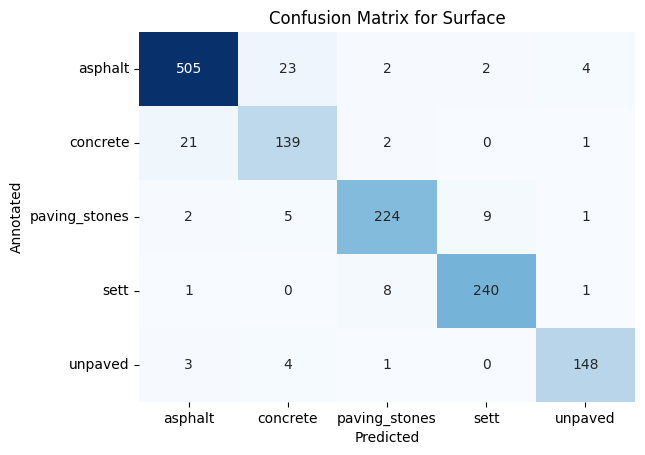

In [81]:
# Plotting the confusion matrix using seaborn heatmap

cm = confusion_matrix(df.surface_true, df.surface_label_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.title(f"Confusion Matrix for Surface")
plt.xlabel("Predicted")
plt.ylabel("Annotated")
plt.show()

In [82]:
# Extract predicted and ground truth values

class_precision = precision_score(df.surface_true, df.surface_label_pred, average='weighted')
class_recall = recall_score(df.surface_true, df.surface_label_pred, average='weighted')

print(f"Count: {len(df)}")
print(f"Precision: {round(class_precision, 2)}")
print(f"Recall: {round(class_recall, 2)}")
print("------------------------")


Count: 1346
Precision: 0.93
Recall: 0.93
------------------------


In [83]:
# all images that were incorrectly classified
misclassification = df[(df.surface_label_pred != df.surface_true) & (df.is_in_validation == 1)]

In [84]:
misclassification = misclassification.sort_values("image_id")
misclassification.reset_index( inplace=True)
misclassification[["image_id", "is_in_validation", 
                   "surface_true", "surface_label_pred", "quality_label_true"]
                   ].to_csv(os.path.join(data_path, "model_predictions", "misclassification_surface.csv"), index=False)

In [85]:
# store missclassified images in folder
import shutil

path = os.path.join(data_path, "model_predictions", "misclassified_images", "surface")
os.makedirs(path, exist_ok=True)
for i in range(len(misclassification)):  # len(misclassification)
    img = misclassification.loc[i]
    img_path = os.path.join(root_data_path, "annotated")
    destination_folder_path = os.path.join(path, img.surface_true, img.surface_label_pred)
    os.makedirs(destination_folder_path, exist_ok=True)
    destination_path = os.path.join(destination_folder_path, f"{img.image_id}.jpg")
    image_filename = os.path.join(img_path, img.surface_true, img.quality_label_true, f"{img.image_id}.jpg")
    shutil.copy(image_filename, destination_folder_path)

In [52]:
# store missclassified images in folder
# path = "/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/metadata/model_predictions/VGG16_V4_not_annotated/missclassified_wo_nostreet"
# os.makedirs(path, exist_ok=True)
# for image_id in misclassification_wo_nostreet.index:
#     destination_path = os.path.join(path, f"{image_id}.jpg")
#     image_filename = os.path.join("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/unsorted_images", f"{image_id}.jpg")
#     shutil.copy(image_filename, destination_path)